<img style="float:right" src="images/logo_va.png" /> 

# Visione Artificiale
## Esercitazione: Analisi di immagini binarie

### Sommario
* Segmentazione oggetti dal background per ottenere una maschera foreground/background
* Utilizzo di tecniche di morfologia matematica per migliorare la maschera
* Etichettatura delle componenti connesse per rimuovere piccoli "buchi" dal foreground
* Etichettatura delle componenti connesse e loro area
* Estrazione del contorno di ogni componente connessa e calcolo della circonferenza minima che lo contiene
* Selezione delle componenti connesse di forma circolare

Iniziamo con l'importazione dei moduli che ci serviranno: `NumPy`, `OpenCV`, `va`. Importiamo anche la funzione `interact` di Jupyter.

In [1]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

Consideriamo l'immagine seguente in cui vogliamo separare gli oggetti dallo sfondo.

""
""

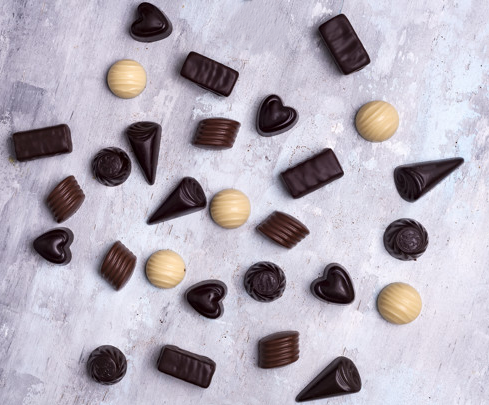

In [2]:
img = cv.imread('analisi/pralines.png')
va.show(img)

Non è un caso particolarmente difficile in quanto lo sfondo è piuttosto omogeneo, tuttavia, come si può verificare nella cella seguente, una semplice conversione in grayscale e binarizzazione con soglia globale non è sufficiente, per la presenza di alcuni oggetti più chiari di alcune parti dello sfondo. 

In [3]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

@interact(soglia=(0,255))
def binarizzazione_globale(soglia=128):
    va.show(cv.threshold(img_gray, soglia, 255, cv.THRESH_BINARY)[1])

interactive(children=(IntSlider(value=128, description='soglia', max=255), Output()), _dom_classes=('widget-in…

<img style="float:left" src="images/ar.png" />**Esercizio 1** - Trovare un metodo per separare i cioccolatini dell'immagine `img` dallo sfondo. La variabile `mask` deve fare riferimento a un'immagine di byte con solo due valori: 255 (foreground) e 0 (background).  
Suggerimenti: un possibile metodo consiste nel convertire l'immagine in HSV e utilizzare: 1) il canale della luminosità per trovare i cioccolatini scuri (con una semplice binarizzazione con soglia globale); 2) il canale hue per individuare i cioccolatini chiari (trovando il particolare range di valori di hue che li caratterizza). La funzione `cv.inRange` può essere utile per costruire delle maschere a partire da range di valori hsv, anche se non è indispensabile utilizzarla.  
Come sempre, si possono aggiungere tutte le celle che si desidera per sperimentare i vari metodi: l'importante è che venga inizializzata la variabile `mask` con il risultato.

In [4]:
# --- Svolgimento Esercizio 1: Inizio --- #

_, mask = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY) # Da sostituire con la soluzione
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
# HSV = hue, saturation, value
# va.show(img_hsv)
# img_hsv.dtype
# _, mask = cv.threshold(img_hsv, 200, 255, cv.THRESH_BINARY)
print(img_hsv.shape)
print(mask.shape)

@interact(soglia=(0,255))
def binarizzazione_globale(soglia=40):
    va.show(img_hsv[:,:,0] > soglia, img_hsv[:,:,1] > soglia, img_hsv[:,:,2] > soglia)
    # va.show(cv.threshold(img_hsv, soglia, 255, cv.THRESH_BINARY)[1])

_, mask = cv.threshold(img_hsv[:,:,1], 40, 255, cv.THRESH_BINARY)

# --- Svolgimento Esercizio 1: Fine --- #    

(405, 489, 3)
(405, 489)


interactive(children=(IntSlider(value=40, description='soglia', max=255), Output()), _dom_classes=('widget-int…

In [5]:
def es1_sol():
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask_scuri = cv.inRange(hsv, (0,0,0), (179,255,102))
    mask_chiari = cv.inRange(hsv, (12,0,0), (23,255,255))
    mask = cv.bitwise_or(mask_chiari, mask_scuri)

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente mostra il risultato ottenuto a fianco di un possibile risultato corretto. Si noti che il risultato non deve essere esattamente quello suggerito: è sufficiente che non sia troppo differente. Come si può notare il risultato non deve essere "perfetto": è normale che ci siano alcuni "buchi" all'interno del foreground e piccole parti del background incorrettamente considerate forground. Nel seguito cercheremo di migliorare la maschera.

Risultato ottenuto (mask),Esempio di risultato corretto
,

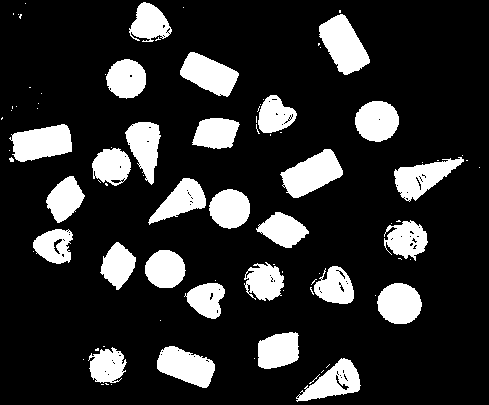
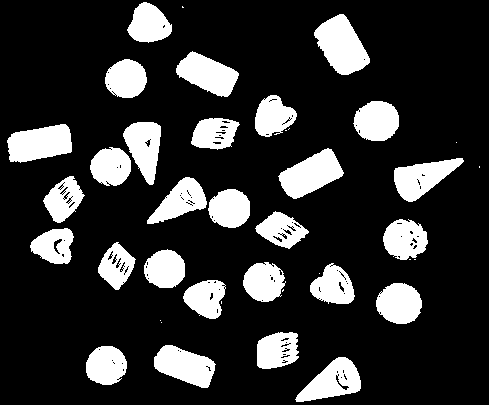

Segmentazione con mask,Segmentazione con l'esempio di risultato corretto
,

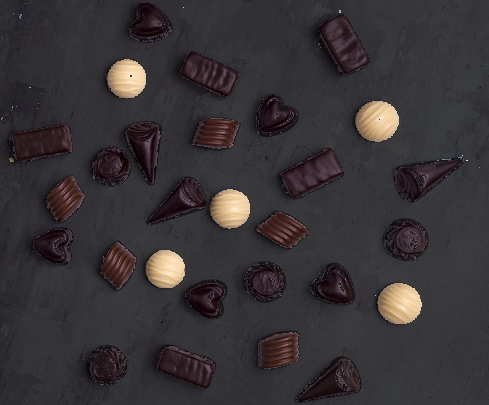
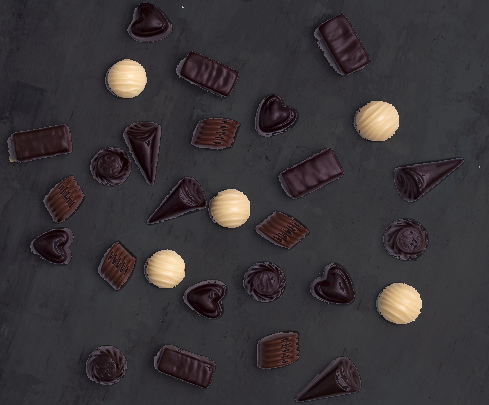

In [6]:
mask_esempio = cv.imread('analisi/mask_esempio.png', cv.IMREAD_GRAYSCALE)
va.show((mask,'Risultato ottenuto (mask)'), (mask_esempio,'Esempio di risultato corretto'))
def am(m): t = img.copy(); t[m==0]//=4; return t
va.show((am(mask),'Segmentazione con mask'), (am(mask_esempio),"Segmentazione con l'esempio di risultato corretto"))

<img style="float:left" src="images/ar.png" />**Esercizio 2** - Osservare il risultato ottenuto nell'esercizio precedente (`mask`): è probabile che nella mascera siano presenti alcuni o tutti i seguenti problemi:

1. alcuni cioccolatini non sono ben "separati", ossia costituiscono un'unica componente connessa;
2. alcuni cioccolatini presentano dei "buchi" o delle "concavità", ossia pixel incorrettamente assegnati al background;
3. alcuni pixel del background sono incorrettamente assegnati al foreground.

Utilizzare tecniche di morfologia matematica per cercare di risolvere tali problemi. In particolare si suggerisce di utilizzare un'operazione di *chiusura* per ridurre il secondo problema, seguita da un'operazione di *apertura* per il primo e il terzo problema. La variabile `mask1` deve fare riferimento alla maschera risultante.  
**Nota bene**: è importante che al termine di questo esercizio tutti i cioccolatini siano separati e non ci siano componenti connesse spurie. In altre parole devono essere completamente risolti i problemi 1 e 3. Il problema 2 può essere ancora presente, purchè i pixel di background all'interno dei cioccolatini siano "buchi": devono essere completamente circondati da pixel di foreground. Quest'ultimo problema, se presente, sarà affrontato nell'esercizio seguente.

In [7]:
# --- Svolgimento Esercizio 2: Inizio --- #

def get_mask1(mask, size):
    mask1 = mask.copy() # Da sostituire con la soluzione
    # print(mask1.shape)

    # se = cv.getStructuringElement(cv.MORPH_RECT, (size, size))
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE, (size, size))

    # c = cv.morphologyEx(mask1, cv.MORPH_CLOSE, se)
    # a = cv.morphologyEx(c, cv.MORPH_OPEN, se)
    # final_res = a

    # apertura poi chiusura funziona meglio
    a = cv.morphologyEx(mask1, cv.MORPH_OPEN, se)
    c = cv.morphologyEx(a, cv.MORPH_CLOSE, se)
    final_res = c

    mask1[final_res==0] = 0
    return mask1

SE_SIZE = 5

@interact(size=(1,50))
def binarizzazione_globale(size=SE_SIZE):
    mask1 = get_mask1(mask, size)
    print("conn m1:", cv.connectedComponents(mask1)[0])
    va.show(mask, mask1)

mask1 = get_mask1(mask, SE_SIZE)

# --- Svolgimento Esercizio 2: Fine --- #   

interactive(children=(IntSlider(value=5, description='size', max=50, min=1), Output()), _dom_classes=('widget-…

In [8]:
def es2_sol():
    pass

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente mostra il risultato ottenuto a fianco di un possibile risultato corretto. Si noti che il risultato non deve essere esattamente quello suggerito: è sufficiente che ci sia una componente connessa per ogni cioccolatino, con eventualmente qualche piccolo "buco".

Risultato ottenuto (mask1),Esempio di risultato corretto
,

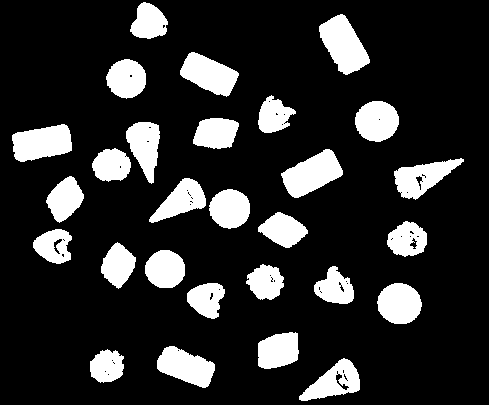
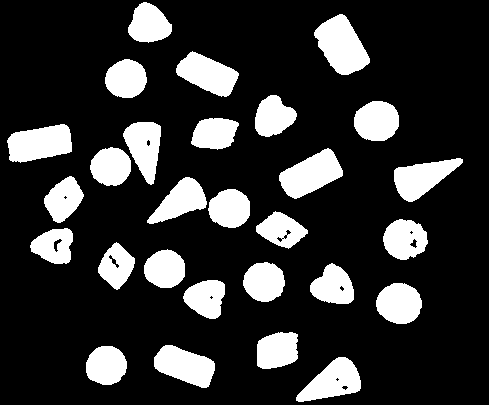

Segmentazione con mask1,Segmentazione con l'esempio di risultato corretto
,

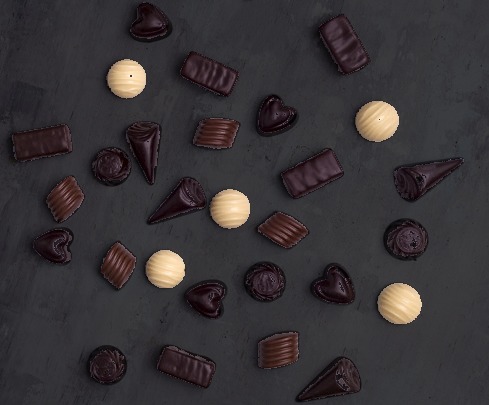
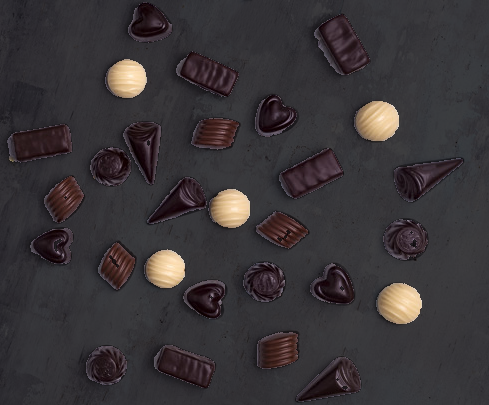

In [9]:
mask1_esempio = cv.imread('analisi/mask1_esempio.png', cv.IMREAD_GRAYSCALE)
va.show((mask1,'Risultato ottenuto (mask1)'), (mask1_esempio,'Esempio di risultato corretto'))
va.show((am(mask1),'Segmentazione con mask1'), (am(mask1_esempio),"Segmentazione con l'esempio di risultato corretto"))

In [10]:
# print(cv.connectedComponents(mask)[0])
# print(cv.connectedComponents(mask_esempio)[0])
print(cv.connectedComponents(mask1)[0])
print(cv.connectedComponents(mask1_esempio)[0])

29
29


Eseguire la cella seguente per verificare che `mask1` contenga il numero atteso di componenti connesse.

In [11]:
va.test_analisi_2(mask1)

Verifica numero di componenti connesse
""


<img style="float:left" src="images/ar.png" />**Esercizio 3** - Costruire una maschera `mask2` a partire da `mask1`, chiudendo eventuali buchi ancora presenti all'interno delle componenti connesse di `mask1`. Se le componenti connesse sono già prive di "buchi" non è necessario eseguire questo esercizio e si può semplicemente copiare `mask1` su `mask2`.  
Suggerimento: un modo semplice per individuare i pixel dei "buchi" è eseguire l'algoritmo dell'etichettatura delle componenti connesse sul negativo di `mask1` (ossia scambiando il background con il foreground). Le componenti connesse trovate saranno il vero background e tante piccole componenti corrispondenti ai "buchi": si possono chiudere i "buchi" assegnando i pixel appartenenti alle componenti connesse con area minore di una certa soglia al foreground.

In [12]:
# --- Svolgimento Esercizio 3: Inizio --- #

mask2 = mask1.copy() # Da sostituire con la soluzione

fg = mask1 == 0
bg = mask1 == 255
temp = mask1.copy()
temp[fg] = 255
temp[bg] = 0
# va.show(mask1, temp)
n, cc, stats, centroids = cv.connectedComponentsWithStats(temp)
print("conn background:", n)

@interact(i=(0,n-1))
def show_stats(i=0):
    res = cv.cvtColor(temp, cv.COLOR_GRAY2BGR)
    x, y = stats[i,cv.CC_STAT_LEFT], stats[i,cv.CC_STAT_TOP]
    w, h = stats[i,cv.CC_STAT_WIDTH], stats[i,cv.CC_STAT_HEIGHT]
    area = stats[i,cv.CC_STAT_AREA]
    cv.rectangle(res, (x,y), (x+w,y+h), (255,0,0), 3)
    va.center_text(res, f'A[{i}]={area}', centroids[i].astype(int), (0,0,255))
    print(area)
    va.show(res)

for i in range(n):
    x, y = stats[i,cv.CC_STAT_LEFT], stats[i,cv.CC_STAT_TOP]
    w, h = stats[i,cv.CC_STAT_WIDTH], stats[i,cv.CC_STAT_HEIGHT]
    area = stats[i,cv.CC_STAT_AREA]
    if area < 100:
        mask2[y:y+h, x:x+w] = 255

n, cc = cv.connectedComponents(mask2)
print("conn mask2:", n)
# va.show(mask2)

# --- Svolgimento Esercizio 3: Fine --- #

conn background: 47


interactive(children=(IntSlider(value=0, description='i', max=46), Output()), _dom_classes=('widget-interact',…

conn mask2: 29


In [13]:
def es3_sol():
    count, cc, stats, _ = cv.connectedComponentsWithStats(cv.bitwise_not(mask1))
    index_small = [i for i,s in enumerate(stats) if s[cv.CC_STAT_AREA]<1000]
    print(index_small)
    va.show(cc)
    mask2 = mask1.copy()
    mask2[np.isin(cc, index_small)] = 255
    va.show(mask2)
# es3_sol()

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente mostra il risultato ottenuto a fianco di un possibile risultato corretto.

Risultato ottenuto (mask2),Esempio di risultato corretto
,

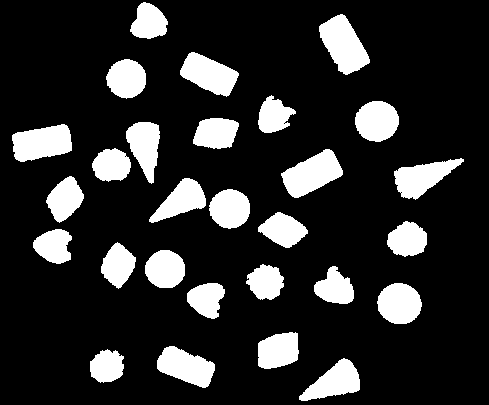
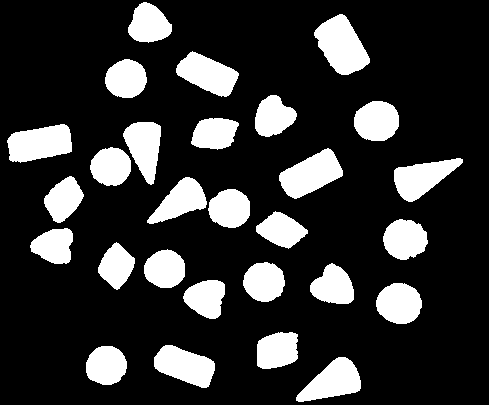

Segmentazione con mask2,Segmentazione con l'esempio di risultato corretto
,

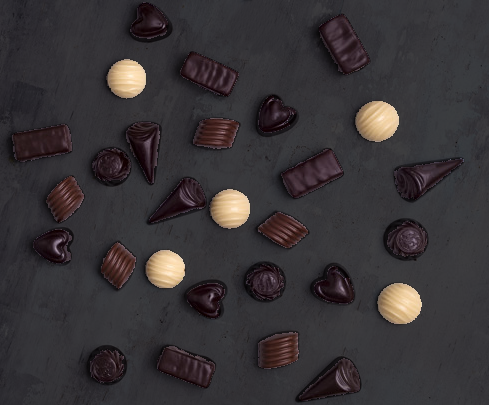
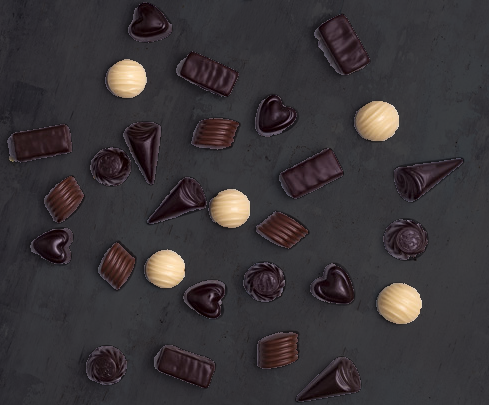

In [14]:
mask2_esempio = cv.imread('analisi/mask2_esempio.png', cv.IMREAD_GRAYSCALE)
va.show((mask2,'Risultato ottenuto (mask2)'), (mask2_esempio,'Esempio di risultato corretto'))
va.show((am(mask2),'Segmentazione con mask2'), (am(mask2_esempio),"Segmentazione con l'esempio di risultato corretto"))

Eseguire la cella seguente per verificare che `mask2` contenga il numero atteso di componenti connesse.

In [15]:
va.test_analisi_3(mask2)

Verifica numero di componenti connesse,Verifica assenza di buchi
,


<img style="float:left" src="images/ar.png" />**Esercizio 4** - Eseguire l'algoritmo di etichettatura delle componenti connesse su `mask2` e calcolare anche l'area (numero di pixel) di ciascuna componente connessa. Inizializzare una lista `cca` contenente, per ciascuna componente connessa (escludendo il background), una tupla `(m, a)` dove `m` è un'immagine binaria con le stesse dimensioni di `mask2` con tutti i pixel a zero tranne quelli della componente connessa (che devono essere pari a 255), mentre `a` è la sua area.

In [16]:
# --- Svolgimento Esercizio 4: Inizio --- #

# cca = [(mask2.copy(), 0)] # Da sostituire con la soluzione
cca = list()
n, labels, stats, centroids = cv.connectedComponentsWithStats(mask2)
# print(labels, labels.shape, labels.dtype)
for i in range(1, n):
    temp = mask2.copy()
    temp[:] = 0
    # x, y = stats[i,cv.CC_STAT_LEFT], stats[i,cv.CC_STAT_TOP]
    # w, h = stats[i,cv.CC_STAT_WIDTH], stats[i,cv.CC_STAT_HEIGHT]
    # area = stats[i,cv.CC_STAT_AREA]
    # temp[y:y+h, x:x+w] = 255
    temp[labels == i] = 255
    # va.show(temp)
    cca.append((temp, stats[i, cv.CC_STAT_AREA]))

# --- Svolgimento Esercizio 4: Fine --- #

In [17]:
def es4_sol():
    def create_cc_mask(index):
        m = np.zeros_like(mask2)
        m[cc==index] = 255
        return m
    count, cc, stats, _ = cv.connectedComponentsWithStats(mask2)
    cca = [(create_cc_mask(i), stats[i, cv.CC_STAT_AREA]) for i in range(1, count)]
    return cca

<img style="float:left" src="images/in.png" />Eseguire la cella seguente per verificare che `cca` contenga il numero atteso di tuple con il formato corretto.

In [18]:
va.test_analisi_4(cca,mask2)

Verifica formato lista cca
""


<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di scorrere la lista `cca` visualizzando il contenuto di ciascun elemento sull'immagine.

In [19]:
@interact(index=(0,len(cca)-1))
def mostra_cca(index=0):
    tmp = img.copy()
    m, a = cca[index]
    tmp[m==255] = (0,255,0)
    x, y, w, h = cv.boundingRect(m)    
    va.center_text(tmp, f'Area={a}', (x+w//2, y+h//2), (255,0,0))
    va.show(tmp)

interactive(children=(IntSlider(value=0, description='index', max=27), Output()), _dom_classes=('widget-intera…

<img style="float:left" src="images/ar.png" />**Esercizio 5** - A partire dalla lista `cca`, costruire una nuova lista `info` che contenga una tupla `(m, c, a, ((xc, yc), r))` per ciascun elemento di `cca`, dove:

* `m` è la stessa maschera contenuta nel corrispondente elemento di `cca`, ossia la maschera della corrispondente componente connessa;
* `c` è il contorno della componente connessa, ottenuto mediante `cv.findContours()`;
* `a` è l'area della componente connessa;
* `((xc, yc), r)` è una tupla contenente le coordinate `(xc, yc)` e il raggio `r` del minimo cerchio che racchiude tutti i pixel del contorno `c`.

Suggerimenti: chiamando `cv.findContours()` su ciascuna componente connessa si possono ottenere i contorni. Prestare attenzione al fatto che `cv.findContours()` restituisce una lista di contorni, ma in questo caso sappiamo che ce ne sarà soltanto uno, per cui `c` sarà semplicemente il primo contorno trovato. `cv.minEnclosingCircle()` permette di trovare `((xc, yc), r)` a partire dal contorno `c`.

In [20]:
# --- Svolgimento Esercizio 5: Inizio --- #

# info = [(mask2.copy(), [np.array(((0,0),(1,1)))], 0, ((100,100), 42))] # Da sostituire con la soluzione
info = list()

for idx, (m, a) in enumerate(cca):
    contours, tree = cv.findContours(m, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    c = contours[0]
    center, radius = cv.minEnclosingCircle(c)
    info.append((m, c, a, (center, radius)))

# --- Svolgimento Esercizio 5: Fine --- #

In [21]:
def es5_sol():
    tmp = [(m, cv.findContours(m, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[0][0], a) for m, a in cca]
    info = [(m, c, a, cv.minEnclosingCircle(c)) for m, c, a in tmp]

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di scorrere la lista `info` visualizzando il contenuto di ciascun elemento sull'immagine.

In [22]:
def ir(x): return int(round(x))

@interact(i=(0,len(info)-1))
def show_info2(i=0):
    m, c, a, ((xc,yc), r) = info[i]
    res = img.copy()
    res[m==0]//=8   
    cv.drawContours(res, c, -1, (0,255,255), 2, cv.LINE_AA)
    cv.circle(res, (ir(xc), ir(yc)), ir(r), (0,128,0), 2, cv.LINE_AA)    
    va.center_text(res, f'{a}', (ir(xc), ir(yc)), (255,255,255))
    va.show(res)

interactive(children=(IntSlider(value=0, description='i', max=27), Output()), _dom_classes=('widget-interact',…

<img style="float:left" src="images/ar.png" />**Esercizio 6** - A partire dalla lista `info`, costruire una nuova lista `tondi` che contenga i soli elementi di `info` che corrispondono a cioccolatini di forma circolare.  
Suggerimento: uno dei modi più semplici consiste nel considerare la differenza fra l'area del cerchio circoscritto e l'area effettiva della componente connessa.

In [23]:
# --- Svolgimento Esercizio 6: Inizio --- #

# tondi = [info[0], info[1], info[2]] # Ovviamente non si possono selezionare "manualmente", trovare un algoritmo!
tondi = list()

for idx, comp in enumerate(info):
    m, c, a, ((xc,yc),r) = comp
    area_circle = r*r*np.pi
    area_comp = a
    # print(idx, area_circle, area_comp)
    if area_circle - area_comp < 300:
        tondi.append(comp)

# --- Svolgimento Esercizio 6: Fine --- #

In [24]:
def es6_sol():
    tondi = [(c, m, a, ((xc, yc), r)) for (c, m, a, ((xc, yc), r)) in info if np.pi * r**2 - a < 200]

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente mostra il risultato ottenuto a fianco del risultato atteso.

Risultato ottenuto,Risultato atteso
,

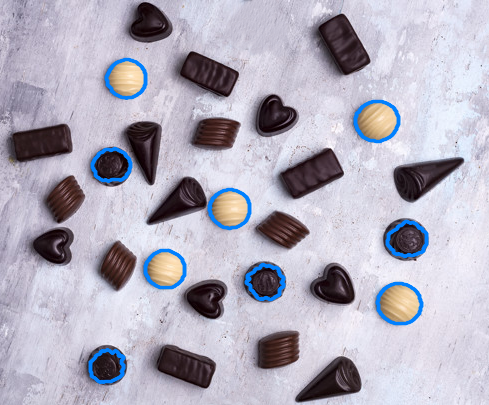
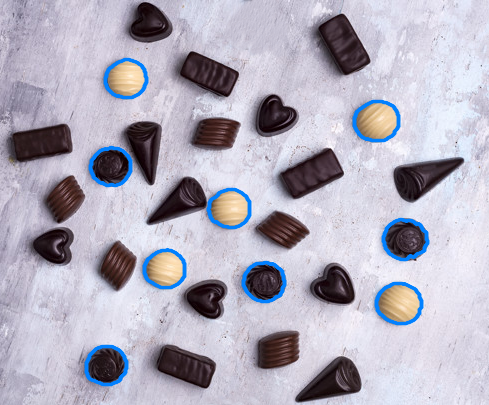

In [25]:
res = img.copy()
for _, c, *_ in tondi:
    cv.drawContours(res, [c], -1, (255,128,0), 2, cv.LINE_AA)
va.show((res,'Risultato ottenuto'), (cv.imread('analisi/res.png'),'Risultato atteso'))